# Denoising Diffusion Implicit Models in a nutshell

## Introduction

Generative models are machine learning models used to create new data samples from old ones. For example we could fit a model to images of faces, and use the model to create new ones. A generative model can be *conditional*, where an additional input can be provided to guide the generation process. Recent popular examples include [DALL·E](https://openai.com/dall-e-2/), where an image is generated based on a user-provided text snippet.

Generative models can be used for a various of purposes in machine learning. One natural application is generation of synthetic data for the purposes of training other machine learning models. Generative models can also be used for filling in missing data, also known as *imputation*. An example application could be filling in missing parts of a picture, or predicting the rating a customer would give to an unseen movie. In section TODO, we show an example of *image interpolation*, where one image is slowly transformed to an other one, slowly mixing features of one to the other.

In this note, we focus on Denoising Diffusion Implicit Models (DDIM), a non-conditional generative model developed by [Song, Chen and Ermon (2020)](https://arxiv.org/abs/2010.02502).
We give a brief summary of the mathematics of DDIM in a digestible form, interspersed with examples and code snippets.
An implementation based on the code snippets, along with pretrained weights, are attached.
Finally, we compare DDIM to the related Denoising Diffusion Probabilistic Models, summarize the main differences and compare performance.

As a technical point, we note that the method described below is a special case of a family of models described by [Song, Chen and Ermon (2020)](https://arxiv.org/abs/2010.02502). The original paper describes a family of models parametrized by a vector of parameters $\sigma$; here we make the choice $\sigma = 0$.

## The big picture

Diffusion models such as DDIM work by slowly turning a input image into random noise in several steps. During this procedure, we train a machine learning model to "learn the noise". To generate a new random picture, we start with random noise, and undo the noise step by step using our model. The final result is a brand new picture, sharing some features of our training images.

### Noising process

 We denote by $x_t$ the image at step $t$. Thus $x_0$ is the original image, and we denote by $x_T$ the fully noised image. We set $T = 1000$. Below is an illustration of the noising process, with samples of $x_0, x_{100}, x_{200}, \dotsc, x_{1000}$ plotted.
 
 ![Noising](assets/noising.png)

The amount of noise added at each step is controlled by a parameter $\alpha_t$, so that $\alpha_t$ is decreasing, $\alpha_0 = 1$ and $\alpha_T \approx 0$. Given an initial image $x_0$, we define noised image at step $t$ by
$$
x_t = \sqrt{\alpha_{t}} x_0 + \sqrt{1-\alpha_{t}} \epsilon_t, \label{foo} \tag{1}
$$
where $\epsilon_t \sim \mathcal{N}(0,I)$ is a standard Gaussian random variable, representing random noise. 

The reason for the choice of $\alpha_t$ is now clear.
Suppose $t$ is small, so $\alpha_t$ is close to $1$. Then $\sqrt{\alpha_t}$ is close to 1, and $\sqrt{1-\alpha_t}$ is close to zero, to the image $x_t$ is mostly the original image $x_0$, with noise close to zero.
On the opposite side, if $t$ is large, then $\alpha_t$ is close to $0$, so $\sqrt{\alpha_t} \approx 0$, and $\sqrt{1-\alpha_t} \approx 1$. This means that for large $t$, $x_t$ is mostly noise, with an almost-zero influence from $x_0$.

We fix an adequate set of parameters $\alpha_t$. The original DDIM paper provides an emipirically reasonable choice, which is described in the implementation section.

### Denoising process

In DDIM, denoising means recovering $x_{t-1}$ from $x_{t}$ and $x_0$. The denoising procedure is defined as follows:
$$
x_{t-1} = \sqrt{\alpha_{t-1}} x_0 + \sqrt{1-\alpha_{t-1}}\epsilon_t \tag{2}
$$
We note a few interesting properties of the formula above. First, we observe that equation (2) is very similar to (1), the only difference being the noise used to get $x_{t-1}$ is actually precisely the same as the one for $x_t$. This means that, **given $x_0$ and $x_t$**, we obtain the previous image $x_{t-1}$ by first finding the noise used to generate $x_t$, and then applying that, with proper scaling, to generate $x_{t-1}$.

Second, note that equation (2) indeed depends on $x_t$, since $\epsilon_t$ can be recovered from equation (1). Indeed, $\epsilon_t = (x_t - \sqrt{a_t} x_0) / \sqrt{1-\alpha_t}$.

Third, and most importantly, denoising **depends on $x_0$**. This is a problem, as it means that to remove noise from $x_t$, we would need to know the original picture $x_0$, thus completely defeating the purpose of the model.

### Machine learning to the rescue

When denoising, we would like to obtain $x_{t-1}$ from $x_t$, without having to know $x_0$. Thus our goal will be to *learn* the noise $\epsilon_t$ used to generate $x_t$ using equation (1).
Learning will be done using a machine learning model, denoted by $\epsilon_\theta^{(t)}$, so that $\epsilon_\theta^{(t)}(x_t)$ is an estimate for $\epsilon_t$ in equation (1). The set of parameters $\theta$ is chosen as to minimize the squared error of our estimate $\epsilon_\theta^{(t)}(x_t)$ compared to a "true" noise $\epsilon_t$.

The training procedure is as follows:
1. Choose a random input image $x_0$ from the training set.
2. Choose a random time $t$ between 1 and $T$.
3. Choose a random noise $\epsilon_t$ from a standard normal distribution
4. Let $x_t = \sqrt{a_t} x_0 + \sqrt{1-\alpha_t} \epsilon_t$
5. Compute the square error between $\epsilon_\theta^{(t)}(x_t)$ and $\epsilon_t$, i.e. $\mathrm{loss} = \| \epsilon_\theta^{(t)}(x_t) - \epsilon_t \|^2_2$.
6. Change parameters $\theta$ so that $\mathrm{loss}$ decreases. In practice, we compute a gradient of the loss function with respect to $\theta$, and take a gradient descent step.

We repeat the above steps until the parameters stabilize.

### Generating samples

We now have all ingredients necessary to reverse the noising procedure.
To obtain a random sample, we start from an $x_T$ consisting of only random noise.
We then denoise using equation (2) as inspiration, filling in unavailable values such as $x_0$ and $\epsilon_t$ using our trained model.

To get $x_{t-1}$ from $x_t$, we proceed as follows:
1. Use the machine learning model to produce $\epsilon_\theta^{(t)}(x_t)$. This will serve as our proxy for $\epsilon_t$.
2. Estimate $x_0$ by solving equation (1) for $x_0$ and using $\epsilon_\theta^{(t)}(x_t)$ in place of $\epsilon_t$. The paper calls this estimate $f_\theta^{(t)}(x_t)$, and is defined as $$f^{(t)}_\theta(x_t) = (x_t - \sqrt{1-\alpha_t} \epsilon_{\theta}^{(t)}(x_t)) / (\sqrt{\alpha_t}) $$
3. Compute $x_{t-1}$ from equation (2) using estimates for $\epsilon_t$ and $x_0$ computed in steps 1 and 2. In symbols $$ x_{t-1} = \sqrt{\alpha_{t-1}} f_\theta^{(t)}(x_t) + \sqrt{1-\alpha_{t-1}} \epsilon_\theta^{(t)}(x_t)$$

We repeat the steps above, going backwards from $x_T$ all the way to $x_0$.

### Faster sampling

Due to the dependence on $x_0$ of the denoising proceduce, we may go from $x_T$ to $x_0$ by skipping some timesteps. The intuitive idea is very similar to the above. Suppose for example we want to go from $x_{200}$ to $x_{100}$ in one go. We use our model to estimate $\epsilon_{200}$ and $x_0$ just as above, and then set $x_{100} = \sqrt{\alpha_{100}} x_0 + \sqrt{1 - \alpha_{100}} \epsilon_{200}$.

For completeness, we describe the steps of the accelerated sampling procedure. Suppose we have a subset $\tau_0 < \tau_1 < \dotsc < \tau_s$, where $\tau_0 = 0$ and $\tau_s = T$. Then, starting from $x_T$, we get $x_0$ by the following procedure
1. Set $t = \tau_i$
1. Use the machine learning model to produce $\epsilon_\theta^{(t)}(x_t)$.
2. Estimate $x_0$ by $$f^{(t)}_\theta(x_t) = (x_t - \sqrt{1-\alpha_t} \epsilon_{\theta}^{(t)}(x_t)) / (\sqrt{\alpha_t}) $$
3. Compute $x_{\tau_{i-1}}$ from equation (2) using estimates for $\epsilon_t$ and $x_0$ computed in steps 1 and 2. In symbols $$ x_{\tau_{i-1}} = \sqrt{\alpha_{\tau_{i-1}}} f_\theta^{(t)}(x_t) + \sqrt{1-\alpha_{\tau_{i-1}}} \epsilon_\theta^{(t)}(x_t)$$

The above steps are repeated $s$ times, which can often be chosen to be much smaller than $T$.

The accelerated sampling procedure can produce worse looking samples and spurious artifacts, but one can often massively reduce the number of required sampling steps and keep the image quality of the full sampling method. Below we present an example of the model trained on MNIST images. The first image consists of 32 generated digits, starting from random noise and going through each step

![1](assets/1.png)

We then use the same starting noise and skip some steps to obtain the images below. In order, we skip 5, 10, and 100 steps at a time. Naturally, the speedup scales linearly, so that skipping 100 steps at a time will yield samples 100 times faster as going through each step.

![5](assets/5.png) ![10](assets/10.png) ![100](assets/100.png)

We observe that the sample quality is barely affected, even when skipping 100 steps at a time. Careful inspection will reveal some artifacts, for example the number 9 on the top right looks more like an 8.

## Minimal implementation

In this section we describe a simple implementation in PyTorch, training on the MNIST dataset.

We start with the usual boilerplate imports and dataset definitions

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

# Cuda
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using {device}')

# Load dataset
dataset = torchvision.datasets.MNIST(root = ".",
                                    download = True,
                                    transform = transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=500,
                                        shuffle=True,
                                        num_workers=4)


Using cpu


For the neural network architecture underlying $\epsilon_\theta^{(t)}$, we use the same one as the DDIM and DDPM papers, which is a variant of a U-net. An implementation in PyTorch is available at [on Github](https://github.com/pesser/pytorch_diffusion), from where we obtained the file [models.py](models.py). Parameters are chosen based on the original DDIM paper, adapted to MNIST images.

In [6]:
from models import Model
model = Model(resolution=28,
                in_channels=1,
                out_ch=1,
                ch=128,
                ch_mult=(1,2,2),
                num_res_blocks=2,
                attn_resolutions=(14,),
                dropout=0.1).to(device)

We define our fixed parameters $T, \alpha$, and our loss function and optimizer. We set $T = 1000$, and choose the same $\alpha$ as the original paper, which is constructed using an auxiliary parameter $\beta$.

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)
loss_fcn = nn.MSELoss()
T = 1000
beta = torch.linspace(0.0001, 0.02, T) # same beta as in DDPM
alpha = torch.cat([torch.tensor([1.]), torch.cumprod(1.-beta,0)]).to(device) # same alpha as in DDIM

As required, $\alpha$ is a decreasing vector, going from 1 to almost 0.

In [9]:
alpha

tensor([1.0000e+00, 9.9990e-01, 9.9978e-01,  ..., 4.2022e-05, 4.1182e-05,
        4.0358e-05])

Next, the training procedure. Our pictures $x_0$ are given as arrays of pixel intensities, ranging from 0 to 1. We start by rescaling them to [-1,1]. We choose a random vector of values $t$, random noise, and compute $x_t$ based on equation (1). We feed our noisy sample to `model` to get an estimate for $\epsilon_t$, and compare the output to the true noise `noise`.

In [ ]:
## Train
model.train()
epochs = 30
for epoch in epochs:
    for XX, y in dataloader:
        X = (XX * 2. - 1.).to(device)
        t = (torch.randint(T, (X.shape[0],)) + 1).to(device)
        noise = torch.randn(X.shape, device = device)
        Xt = alpha[t,None,None,None].sqrt() * X + (1-alpha[t,None,None,None]).sqrt() * noise
        loss = loss_fcn(model(Xt, t), noise)
        print(f'epoch {epoch}, loss: {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    chkpt = deepcopy(model.state_dict())
    torch.save(chkpt, "checkpoint.pt")
torch.save(chkpt, "mnist_weights.pt")

Once the model is trained, we can sample. We start with the "slow" sampling scheme, going through every timestep in reverse. The variable `eps` is our current estimate for $\epsilon_t$, and `X0` is our estimate for $x_0$. The variable `Xt` applies equation (2) on our estimates.

In [18]:
model.load_state_dict(torch.load("mnist_weights.pt", map_location=device))
model.eval()
sample_size = 4
## Normal sample
XT = torch.randn((sample_size,1,28,28), device=device)
with torch.no_grad():
    Xt = XT
    for t in range(T,0,-1):
        print(t)
        t_tensor = torch.full((Xt.shape[0],), t, device=device)
        eps = model(Xt, t_tensor)
        X0 = (Xt - (1-alpha[t]).sqrt() * eps) / alpha[t].sqrt()
        Xt = alpha[t-1].sqrt() * X0 + (1-alpha[t-1]).sqrt() * eps

1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751

At the end, we clamp and scale the pixel values to $[0,1]$ and plot the results.

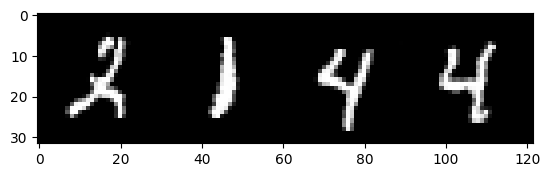

In [20]:
X0_clip = (torch.clip(Xt, -1., 1.) + 1.) / 2.
plt.imshow(TF.to_pil_image(torchvision.utils.make_grid(X0_clip)))

The accelerated sampling procedure is implemented similarly. Below we visit only every 250th timestep. Thus sampling ends after 4 steps, as opposed to 1000, a massive reduction in sampling time. We use the same initial $X_T$ as above, and the result is similar, although suffers a little bit from the small number of steps.

1000
750
500
250


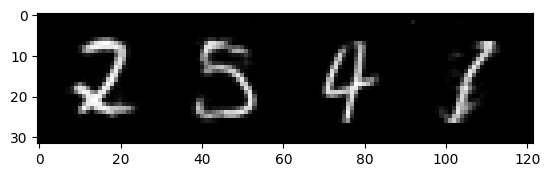

In [17]:
tau = list(range(0,T+1,250))
alpha_tau = alpha[tau]
n_tau = len(tau) - 1
with torch.no_grad():
    Xt = XT
    for i in range(n_tau, 0, -1):
        t = tau[i]
        print(t)
        t_tensor = torch.full((Xt.shape[0],), t, device=device)
        eps = model(Xt, t_tensor)
        X0 = (Xt - (1-alpha_tau[i]).sqrt() * eps) / alpha_tau[i].sqrt()
        Xt = alpha_tau[i-1].sqrt() * X0 + (1-alpha_tau[i-1]).sqrt() * eps
X0_clip = (torch.clip(Xt, -1., 1.) + 1.) / 2.
plt.imshow(TF.to_pil_image(torchvision.utils.make_grid(X0_clip)))

## Comparing to DDPM

DDIM was developed as an improvement over the earlier Denoising Diffusion Probabilistic Models (DDPM), by [Ho, Jain, and Abbeel (2020)](https://arxiv.org/pdf/2006.11239.pdf). As the name suggests, DDPM is also a diffusion based model, where training images are slowly turned to noise, and a machine learning model is used to learn the transitions.

DDIM and DDPM are very closely related, and in fact have the exact same training objective and routine. Indeed, the noising procedure for DDPM is exactly equation (1), and thus a trained DDPM model can be used to sample a DDIM model.

The key difference is that DDPM models don't allow fast sampling by skipping steps. The technical reason is that the noising process in DDPM is a *Markov chain*, where the next step $x_{t+1}$ depends only on the current step $x_t$, and knowing or estimating the initial, non-noisy image $x_0$ adds no information. In contrast, in DDIM the next step depends on both the current step $x_t$, and the original image $x_0$. For this reason, we need to pass through every step when sampling a DDPM.

## Examples

We use the script [mnist_train.py](mnist_train.py) to train a generative model for the MNIST dataset. We train for 30 epochs. While this is relatively low, it still returns acceptable samples. An example for sampling can be found in [mnist_sample.py](mnist_sample.py). All images of handwritten digits above were obtain using our self-trained model.

We demonstrate one feature of generative models, *interpolation*. We start with two sets of random noise $x_T^{(0)}$ and $x_T^{(1)}$. We can smoothly interpolate between the noise by setting $x_T^{(\lambda)} = \lambda x_T^{(1)} + (1-\lambda) x_T^{(0)}$. Thus when $\lambda = 0$ or $1$ we recover $x_T^{(0)}$ or $x_T^{(1)}$ respectively, and when $\lambda$ is between $0$ and $1$, we get a mixture of our noise. We then denoise both $x_T^{(0)}$, $x_T^{(1)}$ and a few pictures inbetween to obtain the sequence below. We see a number 4 slowly become a number 9, and then changing to a 6.

![Interpolation](assets/interpolate.png)

For the CIFAR10 dataset, we download [pretrained DDPM model weights](https://heibox.uni-heidelberg.de/d/01207c3f6b8441779abf/) courtesy of the following reimplementation of the original DDPM model in Pytorch: https://github.com/pesser/pytorch_diffusion. This set of weights is trained for 790000 epochs. Below we randomly generate 64 samples in 10 timesteps. This takes about a minute on a several years old MacBook Pro, and under a second on a GPU. The code to generate the image below can be found in [cifar_sample.py](cifar_sample.py).

![CIFAR sample](assets/cifar.png)